In [155]:

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from scipy import ndimage
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#Change path to where your BRATS20 data is located
os.chdir('/users/0/avela019/Desktop/EE5561_project')

TRAIN_DATASET_PATH = 'BRATS20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'BRATS20/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'


cuda


In [153]:
#Define dataset for the training
class BRATS_dataset(Dataset):
    """
    Dataset class for the brain tumor segmentation data using a 2.5D slice setup
    
    INPUTS:
    dataset_path: path leading to the "MICCAI_BraTS2020_TrainingData" directory
    num_slices: number of slices in each 2.5D slab
    downsamp_ratio: factor by which data is downsampled
    downsamp_type: what kind of downsampling to use
    data_shape: size of each volume
    num_volumes: number of volumes to be used for the dataset. The default value is to use all volumes availeable.
    """
    
    def __init__(self, dataset_path, device, num_slices = 3, downsamp_ratio = 2, downsamp_type = 'bicubic', data_shape = [240, 240, 155], num_volumes = np.inf):
        
        self.dataset_path = Path(dataset_path)
        self.device = device
        self.num_slices = num_slices
        self.downsamp_ratio = downsamp_ratio
        self.data_shape = data_shape
        self.downsamp_type = downsamp_type
        self.slices_per_volume = data_shape[2] - 2*(num_slices//2)

        subdir_list = [p for p in self.dataset_path.iterdir() if p.is_dir()]
        
        if(len(subdir_list) > num_volumes):
            subdir_list = subdir_list[:num_volumes]
        
        self.num_volumes = len(subdir_list)
        
        #Total length of the dataset = number of 2.5D slices * number of volumes
        self.length = self.slices_per_volume * self.num_volumes
        
    def __len__(self):
        return self.length
    
    def downsize(self, img):
        #Downsaize in each channel
        ds = 1/float(self.downsamp_ratio)
        if self.downsamp_type == 'bicubic':
            downscaled_image = ndimage.zoom(img, (ds, ds, 1), order=3)
        if self.downsamp_type == 'bilinear':
            downscaled_image = ndimage.zoom(img, (ds, ds, 1), order=1)

        return downscaled_image

    def __getitem__(self, idx):
        #Each idx will get one 2.5D slice of a particular volume
        volume_idx = idx // self.slices_per_volume
        slice_idx = idx % self.num_volumes
        slice_range = np.arange(slice_idx, slice_idx + self.num_slices)
        
        volume_path = subdir_list[volume_idx]
        file_list = [p for p in volume_path.iterdir() if p.is_file()]
        
        #List of all volumes
        vol_list = [nib.load(file_list[i]).get_fdata() for i in range(5)]
        
        #Get only the needed 2.5D slice
        data_list = [vol[:,:,slice_range] for vol in vol_list]
        
        #Get segmentation mask from the list and extract its central slice
        mask = data_list.pop(1)[:,:,self.num_slices//2].squeeze()
        
        #Normalize each 2.5D slice
        img_list = [img/img.max() if img.max()>0 else img for img in data_list]
        
        #Downsample each slice
        ds_img_list = [self.downsize(img) for img in img_list]
        
        img_list = [torch.from_numpy(img).to(self.device) for img in img_list]
        ds_img_list = [torch.from_numpy(img).to(self.device)  for img in ds_img_list]
        mask = torch.from_numpy(mask).to(self.device) 
        
        #Image list contains 2.5D slices of: flair, t1, t1ce, t2 (in order)
        return img_list, ds_img_list, mask
    

<Figure size 640x480 with 0 Axes>

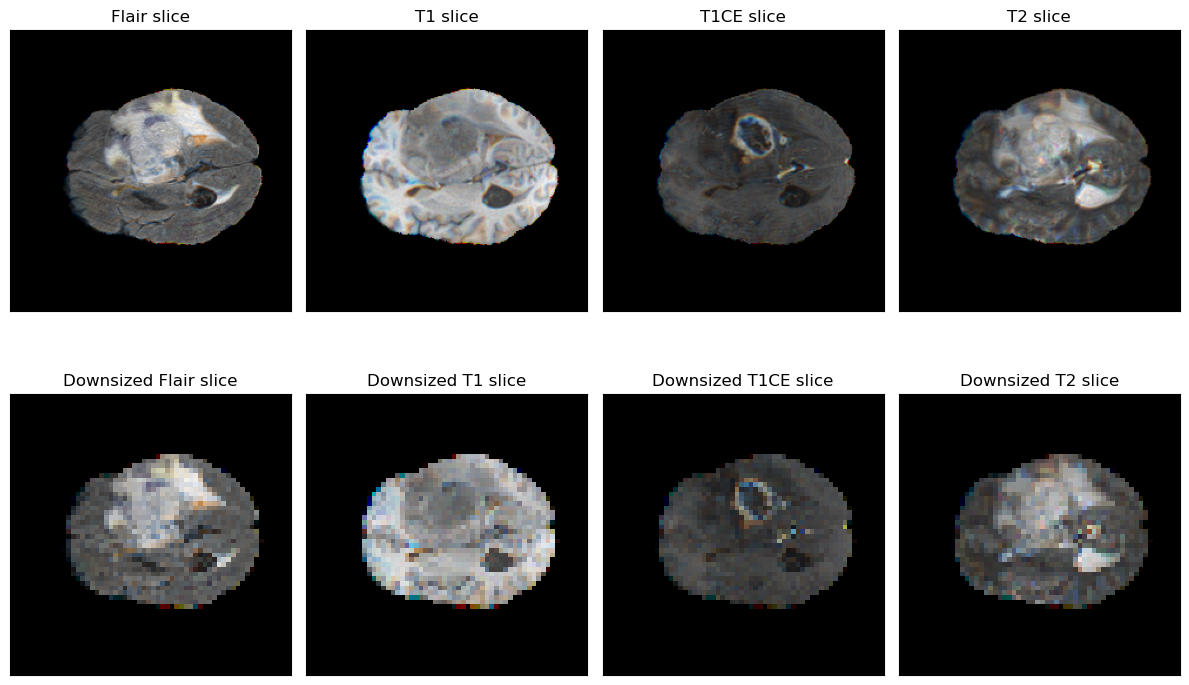

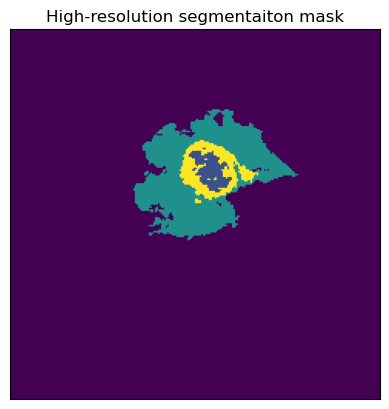

In [154]:

test_dataset = BRATS_dataset(TRAIN_DATASET_PATH, device, num_slices = 3, downsamp_ratio = 4, downsamp_type = 'bilinear')
test_loader = DataLoader(test_dataset, batch_size=1)
iter_loader = iter(test_loader)

idx = 70

img_list, ds_img_list, mask = test_dataset[70]
    
img_labels = ["Flair", "T1", "T1CE", "T2"]

plt.gray()
fig,ax = plt.subplots(2,4, figsize=(12,8))

for j in range(4):
    ax[0,j].imshow(img_list[j].cpu().detach())
    ax[0,j].set_title(img_labels[j] + " slice")
    ax[1,j].imshow(ds_img_list[j].cpu().detach())
    ax[1,j].set_title("Downsized " + img_labels[j] + " slice")
    

for ax in fig.get_axes():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='y', length=0)
    
fig.tight_layout()
fig.show()

plt.figure()
plt.imshow(mask.cpu().detach(), cmap = 'viridis')
plt.title("High-resolution segmentation mask")
plt.xticks([])
plt.yticks([])
plt.show()



In [3]:
 !pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.9 MB 20.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 92.1 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 655 kB/s s eta 0:00:01
     |████████████████████████████████| 315 kB 57.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 83.2 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 49.9 MB/s eta 0:00:01
     |████████████████████████████████| 220 kB 105.4 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
import sys
print(sys.executable)
!which pip
!pip show scikit-image

!{sys.executable} -m pip install scikit-image

import skimage

/users/0/avela019/.conda/envs/parallel_recon/bin/python
/common/software/install/migrated/anaconda/miniconda3_4.8.3-jupyter/bin/pip
Name: scikit-image
Version: 0.21.0
Summary: Image processing in Python
Home-page: https://scikit-image.org
Author: None
Author-email: None
License: Files: *
        Copyright: 2009-2022 the scikit-image team
        License: BSD-3-Clause
        
        Files: doc/source/themes/scikit-image/layout.html
        Copyright: 2007-2010 the Sphinx team
        License: BSD-3-Clause
        
        Files: skimage/feature/_canny.py
               skimage/filters/edges.py
               skimage/filters/_rank_order.py
               skimage/morphology/_skeletonize.py
               skimage/morphology/tests/test_watershed.py
               skimage/morphology/watershed.py
               skimage/segmentation/heap_general.pxi
               skimage/segmentation/heap_watershed.pxi
               skimage/segmentation/_watershed.py
               skimage/segmentation/_wa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 173.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-image] [scikit-image]
